# 11.3.6 Learning Rate Scheduling 学習率のスケジューリング

## 目的

一定の学習率を利用するより、学習中、動的に学習率を変更することで、より早く高い精度のモデルが得られること多い。

これを **Learning Rate Scheduling**と呼ぶ。このセクションでは、以下のLearning Rate Schedulingの手法について学ぶ。

- Power Scheduling
- Exponential Scheduling
- Piecewise Constant Scheduling
- Performance Scheduling
- 1Cycle Scheduling

## 結論を言うと・・・

結論を言うと、以下は収束までの時間を大幅に短縮することができる

- Exponential Scheduling
- Performance Scheduling
- 1Cycle Scheduling

## Note

- 本書は、SGDを用いて学習率を調整している。オプティマイザーが変わると動的に調整するパラメータが変わるかもしれない。
- たとえば1CycleSchedulingにおいて、SGDではなくモーメンタム最適化を利用する例が紹介されている
    - このとき、学習率の代わりにモーメンタムを学習の進捗に合わせて調整する
        - モーメンタムのbetaを高い=>低い=>高い
- Adam, RMSProp, AddGrad は、実質的にηの動的調整が入ることを考慮
    - 他のオプティマイザと比較して、あまりηのスケジューリングにこだわる必要はないかもしれない？

## サンプルコードを動かすための事前準備

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Power Scheduling

### Power Schedulingの定義

```lr = lr0 / (1 + steps / s)**c```

#### 一般的には...

$$
\begin{align}
&l_r=\frac{l_{ro}}{\left(1+\frac{steps}{s}\right)^c}
\end{align}
$$

- `lr0`: 初期学習率
- `c`: 指数, 一般的に1
- `s`: 減衰のスピードをきめるハイパーパラメータ
- `steps`: 全データ数 × エポック数 / バッチ数

#### Kerasの場合`c=1`として...

$$
\begin{align}
&l_r=\frac{l_{ro}}{1+steps\cdot decay} \\
&decay = \frac{1}{s} \\
\end{align}
$$

### スケジューリング指定方法

- Power scheduling が最も簡単なスケジュール設定方法である
- `decay` を設定するだけで良い

In [4]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Metal device set to: Apple M1


2022-08-05 13:53:26.084024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 13:53:26.084157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

2022-08-05 13:53:29.501641: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-05 13:53:29.609262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/25
1716/1719 [============================>.] - ETA: 0s - loss: 0.4904 - accuracy: 0.8268

2022-08-05 13:53:41.766152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 13s 7ms/step - loss: 0.4900 - accuracy: 0.8270 - val_loss: 0.4059 - val_accuracy: 0.8596
Epoch 2/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3791 - accuracy: 0.8654 - val_loss: 0.3826 - val_accuracy: 0.8668
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3455 - accuracy: 0.8776 - val_loss: 0.3644 - val_accuracy: 0.8742
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3234 - accuracy: 0.8853 - val_loss: 0.3565 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3073 - accuracy: 0.8903 - val_loss: 0.3460 - val_accuracy: 0.8784
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2936 - accuracy: 0.8958 - val_loss: 0.3414 - val_accuracy: 0.8800
Epoch 7/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2830 - accuracy: 0.8994 - val_loss: 0.3422 - val_accuracy: 0.8

### Epoch vs Learning Rate

- ステップ数 = データ数/バッチ数であることに注意
- epoch * n_steps_per_sporch /s = 1になると、lrは半分になる

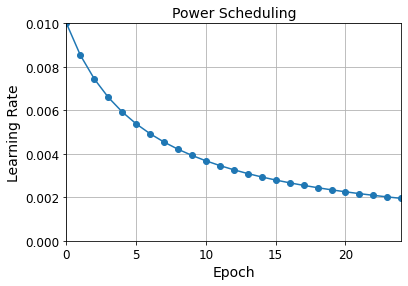

In [7]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Exponential Scheduling (指数スケジューリング)

### Expornential Schedulingの定義

```lr = lr0 * 0.1**(epoch / s)```


$$
\begin{align}
&l_r=l_{ro}\cdot \left(\frac{1}{10}\right)^{\frac{epoch}{s}}
\end{align}
$$

### スケジューリング指定方法

Kerasのコールバックを使う

- `exponential_decay_fn`: 指数スケジューリングを満たす俺々スケジューリング関数を用意
- `lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)`
- `model.fit(...., callbacks=[lr_scheduler])`

In [8]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [9]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

# 関数オブジェクトを返す
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [11]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25


2022-08-05 13:58:59.613747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.7671

2022-08-05 13:59:16.164217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 17s 10ms/step - loss: 0.8288 - accuracy: 0.7671 - val_loss: 0.9592 - val_accuracy: 0.7234
Epoch 2/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6672 - accuracy: 0.8012 - val_loss: 0.6911 - val_accuracy: 0.7994
Epoch 3/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6029 - accuracy: 0.8150 - val_loss: 0.6247 - val_accuracy: 0.8232
Epoch 4/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5523 - accuracy: 0.8315 - val_loss: 0.6038 - val_accuracy: 0.8286
Epoch 5/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4891 - accuracy: 0.8449 - val_loss: 0.7304 - val_accuracy: 0.8520
Epoch 6/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4683 - accuracy: 0.8554 - val_loss: 0.5577 - val_accuracy: 0.8562
Epoch 7/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4183 - accuracy: 0.8641 - val_loss: 0.5654 - val_accuracy: 0

### Epochs vs Learning Rate

- ステップ数 = データ数/バッチ数であることに注意
- ステップ数 = s で 1/10となる

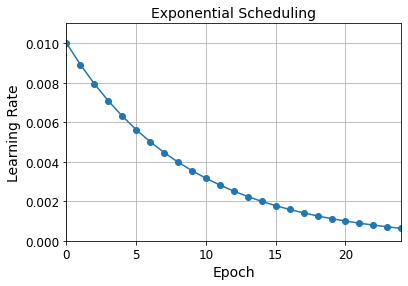

In [12]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 現在の学習率を引数として受け取るには？ (エポック毎の場合)

The schedule function can take the current learning rate as a second argument:

スケジュール関数は、現在の学習率を `2番目の引数` として受け取ることができます。

In [13]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

### 現在の学習率を引数として受け取る (エポックでなくてバッチ毎に受け取る場合)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

エポックごとではなく反復ごとに学習率を更新する場合は、独自のコールバック クラスを作成する必要があります。

#### 複雑なのでいったん図でイメージ, `10.2.7の page308` も参考にすること

- `keras.callbacks.Callback` を継承した俺々クラスを作成
- `on_batch_begin`メソッドをカスタマイズ
- `on_epoch_end`メソッドをカスタマイズ

![](https://docs.google.com/drawings/d/e/2PACX-1vTXEpRjNd7NMhcwEwk8kNruL6FuOkZl6-IjxXCuDzr6m8310SD-4lhIeMKTbafyFBxt6znnGqCVqkN5/pub?w=946&h=623)

In [14]:
K = keras.backend

# keras.callbacks.Callbackを継承して俺々コールバッククラスを作る
class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25


2022-08-05 14:05:42.741277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1717/1719 [============================>.] - ETA: 0s - loss: 0.8010 - accuracy: 0.7655

2022-08-05 14:06:00.082001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 18s 10ms/step - loss: 0.8013 - accuracy: 0.7656 - val_loss: 0.7799 - val_accuracy: 0.7788
Epoch 2/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6584 - accuracy: 0.8009 - val_loss: 0.4953 - val_accuracy: 0.8506
Epoch 3/25
1719/1719 [==============================] - 18s 11ms/step - loss: 0.5570 - accuracy: 0.8255 - val_loss: 0.5626 - val_accuracy: 0.8450
Epoch 4/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5067 - accuracy: 0.8419 - val_loss: 0.4932 - val_accuracy: 0.8528
Epoch 5/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4548 - accuracy: 0.8549 - val_loss: 0.4981 - val_accuracy: 0.8394
Epoch 6/25
1719/1719 [==============================] - 18s 11ms/step - loss: 0.4085 - accuracy: 0.8668 - val_loss: 0.4624 - val_accuracy: 0.8704
Epoch 7/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3956 - accuracy: 0.8742 - val_loss: 0.4247 - val_accura

In [15]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)
print("n_epochs", n_epochs)
print("len(X_train)", len(X_train))
print("n_steps(エポック25分の全ステップ数)", n_steps)

n_epochs 25
len(X_train) 55000
n_steps(エポック25分の全ステップ数) 42968


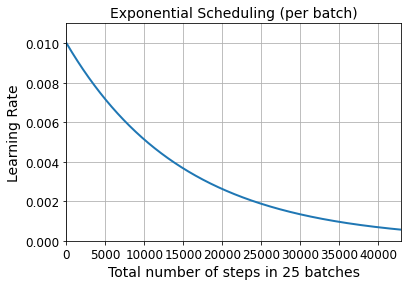

In [16]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Total number of steps in 25 batches")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

## Piecewise Constant Scheduling (部分毎に一定の学習率をあらかじめ決めて置く方法)

- 適切な学習率と継続期間を予め明らかにするためには試行錯誤が必要になる (めんどうかも？)

### スケジューリング指定方法

- 基本的には指数スケジューリングと同様
    - `keras.callbacks.LearningRateScheduler` コールバックを利用する
- オレオレ関数の引数の一番目にepoch情報が入るので、それを使って制御する

In [17]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [18]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [19]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25


2022-08-05 14:13:00.644694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1715/1719 [============================>.] - ETA: 0s - loss: 0.8456 - accuracy: 0.7562

2022-08-05 14:13:16.492048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 17s 9ms/step - loss: 0.8457 - accuracy: 0.7562 - val_loss: 0.8634 - val_accuracy: 0.8200
Epoch 2/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8284 - accuracy: 0.7698 - val_loss: 0.8527 - val_accuracy: 0.7298
Epoch 3/25
1719/1719 [==============================] - 16s 9ms/step - loss: 1.1529 - accuracy: 0.6042 - val_loss: 1.0814 - val_accuracy: 0.6254
Epoch 4/25
1719/1719 [==============================] - 16s 9ms/step - loss: 1.0730 - accuracy: 0.5982 - val_loss: 0.9615 - val_accuracy: 0.6252
Epoch 5/25
1719/1719 [==============================] - 16s 9ms/step - loss: 1.0672 - accuracy: 0.5958 - val_loss: 1.0511 - val_accuracy: 0.6312
Epoch 6/25
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8319 - accuracy: 0.6579 - val_loss: 0.9114 - val_accuracy: 0.6696
Epoch 7/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8080 - accuracy: 0.6720 - val_loss: 1.0982 - val_accuracy: 0.

### Epochs vs Learning Rate

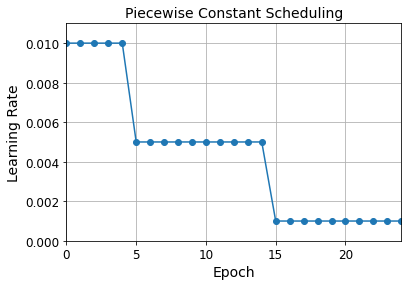

In [20]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Performance Scheduling 性能によるスケジューリング

誤差の低下が止まると、学習率を低下していく方法

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

### スケジューリング指定方法

- `keras.callbacks.ReduceLROnPlateau`コールバック が用意されている
- 以下、最良の検証損失が向上しなければ、学習率に0.5をかけていく

In [22]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

# callbacks引数に上記lr_schedulerを渡す
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
  15/1719 [..............................] - ETA: 13s - loss: 1.7049 - accuracy: 0.5458

2022-08-05 14:19:45.108221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1717/1719 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy: 0.8051

2022-08-05 14:19:56.873357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 12s 7ms/step - loss: 0.6032 - accuracy: 0.8051 - val_loss: 0.4798 - val_accuracy: 0.8474
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4939 - accuracy: 0.8402 - val_loss: 0.5513 - val_accuracy: 0.8370
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5191 - accuracy: 0.8414 - val_loss: 0.5743 - val_accuracy: 0.8408
Epoch 4/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5149 - accuracy: 0.8458 - val_loss: 0.4950 - val_accuracy: 0.8514
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5257 - accuracy: 0.8485 - val_loss: 0.4692 - val_accuracy: 0.8546
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4962 - accuracy: 0.8569 - val_loss: 0.5070 - val_accuracy: 0.8644
Epoch 7/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5088 - accuracy: 0.8559 - val_loss: 0.5333 - val_accuracy: 0.8

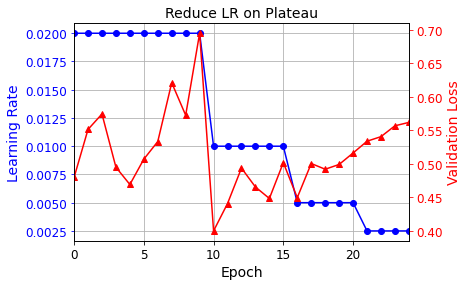

In [23]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## tf.keras限定, 別のスケジューリング指定方法の紹介

tf.keras限定で別のスケジューリング指定方法があるので、紹介する

先程説明した exponential_decay_fn() の別の方法

In [24]:
# モデル作成
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# 指数スケジューリングの設定
# 20エポック * ステップ数で学習率が1/10になるように設定
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)

# optimizersの引数にわたす。以下はOptimizerとしてSGDを利用している場合
optimizer = keras.optimizers.SGD(learning_rate)

# compileでoptimizerを渡す
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
  15/1719 [..............................] - ETA: 13s - loss: 1.5010 - accuracy: 0.4875

2022-08-05 14:25:01.092540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.8285

2022-08-05 14:25:13.640234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 13s 8ms/step - loss: 0.4870 - accuracy: 0.8285 - val_loss: 0.4004 - val_accuracy: 0.8614
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3797 - accuracy: 0.8650 - val_loss: 0.3653 - val_accuracy: 0.8732
Epoch 3/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3459 - accuracy: 0.8772 - val_loss: 0.3655 - val_accuracy: 0.8736
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3245 - accuracy: 0.8847 - val_loss: 0.3429 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3086 - accuracy: 0.8903 - val_loss: 0.3367 - val_accuracy: 0.8826
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2942 - accuracy: 0.8959 - val_loss: 0.3353 - val_accuracy: 0.8818
Epoch 7/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2841 - accuracy: 0.8987 - val_loss: 0.3296 - val_accuracy: 0.8

In [25]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

In [26]:
print(learning_rate)

## 1Cycle scheduling

横軸をステップ数としたとき、下記のようなプロファイルで学習率を調整する。

- η1は学習率曲線を描いてやって、それで求めてやる

![](https://docs.google.com/drawings/d/e/2PACX-1vRaUwCD0e8VMlXnl2clFZw-1ZHJP4H71dfJFVllmKhSVyW1bZvBpryDmJJt3-JvDQ9hIyZQJeLTX2ib/pub?w=915&h=445)

### STEP1: η1を決定する

In [32]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

警告 on_batch_end()メソッドでは、logs["loss"]にバッチロスが含まれていましたが、TensorFlow 2.2.0では平均ロス（エポック開始からの）に置き換えられています。このため、下のグラフは書籍よりもずっと滑らかです（TF 2.2以降を使用している場合）。また、バッチロスが爆発的に増え始めてから、その爆発がグラフで明らかになるまでにタイムラグがあることも意味します。ですから、「ノイズの多い」グラフのときよりも、少し小さめの学習率を選ぶとよいでしょう。あるいは、上記のExponentialLearningRateコールバックを微調整して、（現在の平均損失と以前の平均損失に基づいて）バッチ損失を計算するようにすることもできる。

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
```

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

 12/430 [..............................] - ETA: 4s - loss: 2.8759 - accuracy: 0.1055

2022-08-05 14:30:36.041429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


430/430 [==============================] - 4s 10ms/step - loss: nan - accuracy: 0.3733


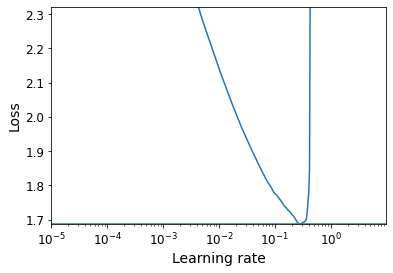

In [29]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

### OneCycleSchedulerを開始

In [30]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        print("self.start_rate :", self.start_rate)
        print("self.max_rate   :", self.max_rate)
        print("self.last_rate  :", self.last_rate)
        print("self.iterations:", self.iterations)
        print("self.half_iteration:", self.half_iteration)
        print("self.last_iterations:", self.last_iterations)
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [31]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

self.start_rate : 0.005
self.max_rate   : 0.05
self.last_rate  : 5e-06
self.iterations: 10750
self.half_iteration: 4837
self.last_iterations: 1076
Epoch 1/25
428/430 [============================>.] - ETA: 0s - loss: 0.6538 - accuracy: 0.7714

2022-08-05 14:30:44.690463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


430/430 [==============================] - 4s 9ms/step - loss: 0.6530 - accuracy: 0.7717 - val_loss: 0.4807 - val_accuracy: 0.8350
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.4553 - accuracy: 0.8405 - val_loss: 0.4252 - val_accuracy: 0.8556
Epoch 3/25
430/430 [==============================] - 4s 9ms/step - loss: 0.4104 - accuracy: 0.8553 - val_loss: 0.4097 - val_accuracy: 0.8556
Epoch 4/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3814 - accuracy: 0.8650 - val_loss: 0.3836 - val_accuracy: 0.8638
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3613 - accuracy: 0.8716 - val_loss: 0.3676 - val_accuracy: 0.8704
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3427 - accuracy: 0.8772 - val_loss: 0.3650 - val_accuracy: 0.8718
Epoch 7/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3296 - accuracy: 0.8814 - val_loss: 0.3546 - val_accuracy: 0.8752
Epoch 8/25
430/43